1) Load Dataset (Generate random samples)

In [6]:
import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from mpl_toolkits import mplot3d
from sklearn.metrics import pairwise_distances_argmin
#you can use Python’s imaging library (PIL)
from PIL import Image
from IPython.display import display
# or you can use opencv ## conda install anaconda::opencv
import cv2 #if you use cv2 remember to covert from BGR to RGB
import scipy.cluster.hierarchy as sch #you only for sch.dendrogram

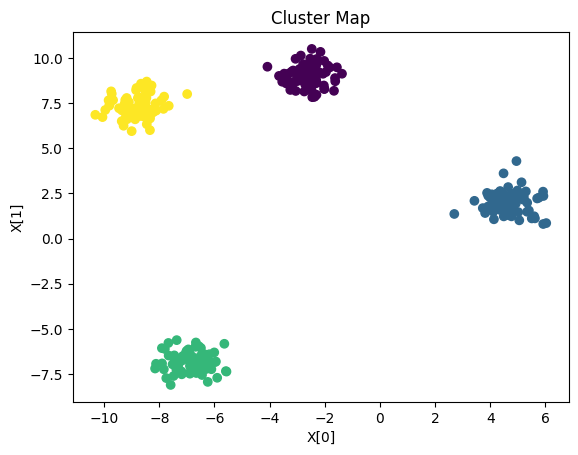

In [12]:
X, y = make_blobs(n_samples = 300, centers = 4, cluster_std = 0.6, random_state = 42)

plt.figure()
plt.scatter(X[:,0], X[:,1], c = y, cmap = "viridis")
plt.xlabel("X[0]")
plt.ylabel("X[1]")
plt.title("Cluster Map")
plt.show()

2) Define KMeans Model

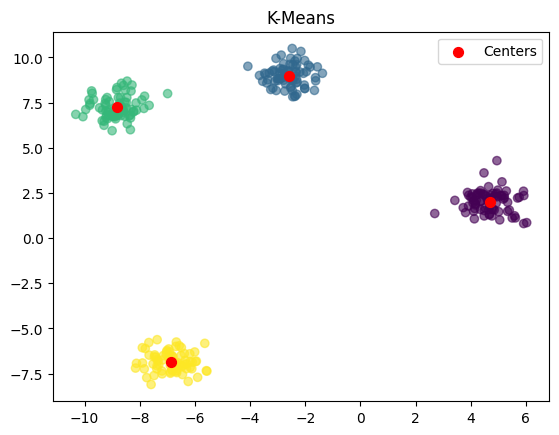

In [13]:
class KMeans:
    def __init__(self, k = 4, max_iterations = 500, tolerance = 1e-4):
        #self.X = X
        self.k = k
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.centers = None
        self.label_ = None

    def _kppInit(self, X):
        np.random.seed(42)
        centers = [X[np.random.randint(X.shape[0]),:]]
        for _ in range(1, self.k):
            dist = np.min([np.linalg.norm(X-c, axis = 1) for c in centers], axis = 0)
            probs = dist / np.sum(dist)
            new_centers = X[np.random.choice(X.shape[0], p=probs)]
            centers.append(new_centers)
        return np.array(centers)

    def _assign_clusters(self, X):
        distance = np.linalg.norm(X[:,np.newaxis] - self.centers, axis = 2)
        return np.argmin(distance, axis = 1)

    def _compute_centers(self, X, clusters):
        return np.array([X[clusters == i].mean(axis = 0)for i in range(self.k)])

    def fit(self, X, kpp_init):
        if(kpp_init):
            self.centers = self._kppInit(X)
        else:
            self.centers = X[np.random.choice(X.shape[0], self.k, replace = False)]



        for _ in range(self.max_iterations):
            clusters = self._assign_clusters(X)
            new_centers = self._compute_centers(X, clusters)

            if np.all(np.linalg.norm(new_centers - self.centers, axis=1) < self.tolerance):
                break

            self.centers = new_centers
        self.label_ = clusters

    def predict(self, X):
        return self._assign_clusters(X)

    def returnLabels(self):
        return self.label_

    def returnCenters(self):
        return self.centers


KMmodel = KMeans(k = 4)
KMmodel.fit(X, False)
clusters = KMmodel.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(KMmodel.centers[:, 0], KMmodel.centers[:, 1], c='red', marker='o', s=50, label='Centers')
plt.legend()
plt.title("K-Means")
plt.show()


3) Plot and Compare KMeans and K++ initialized model

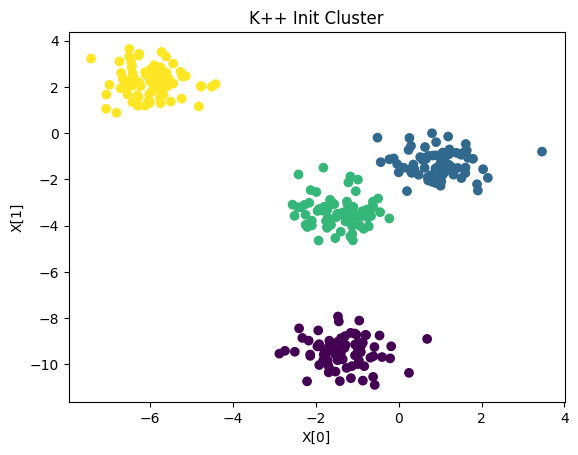

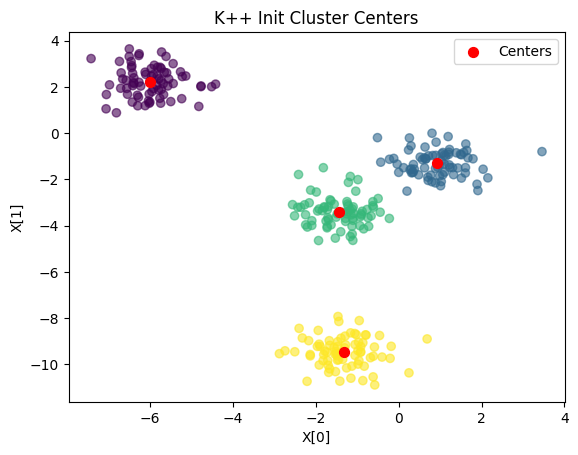

In [9]:
X, y = make_blobs(n_samples = 300, centers = 4, cluster_std = 0.6, random_state = 2)

plt.figure()
plt.scatter(X[:,0], X[:,1], c = y, cmap = "viridis")

plt.title("K++ Init Cluster")
plt.xlabel("X[0]")
plt.ylabel("X[1]")
plt.show()

ran2model = KMeans(k = 4)
ran2model.fit(X, True)
clusters = ran2model.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(ran2model.centers[:, 0], ran2model.centers[:, 1], c='red', marker='o', s=50, label='Centers')
plt.legend()
plt.title("K++ Init Cluster Centers")
plt.xlabel("X[0]")
plt.ylabel("X[1]")
plt.show()

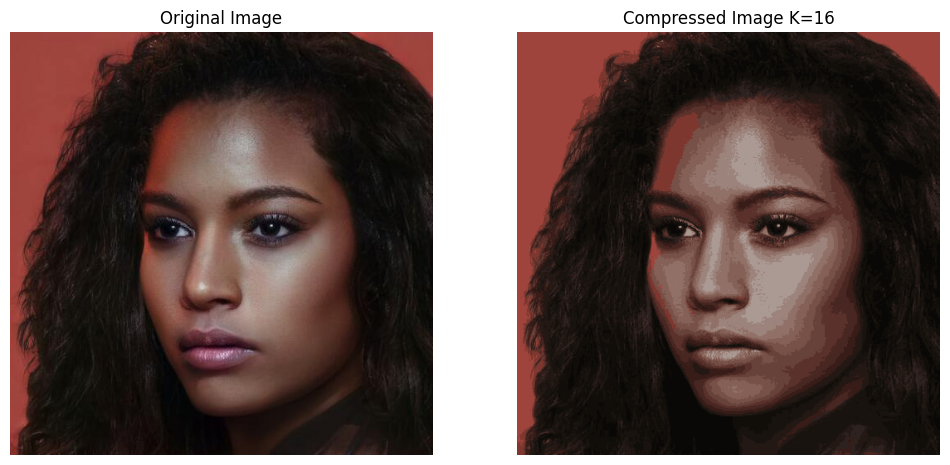

In [11]:
img = Image.open("cropped.jpg")
imgMatrix = np.array(img).reshape(-1,3)
processed_img = np.asarray(img)

imgKmeans = KMeans(k = 16)
imgKmeans.fit(imgMatrix, True)
centers = imgKmeans.returnCenters()
labels = imgKmeans.returnLabels()

compressed_img = np.array([centers[label] for label in labels], dtype=np.uint8)
compressed_img = compressed_img.reshape(processed_img.shape)

compressed_img = Image.fromarray(compressed_img)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[0].axis("off")
ax[1].imshow(compressed_img)
ax[1].set_title("Compressed Image K=16")
ax[1].axis("off")

plt.show()

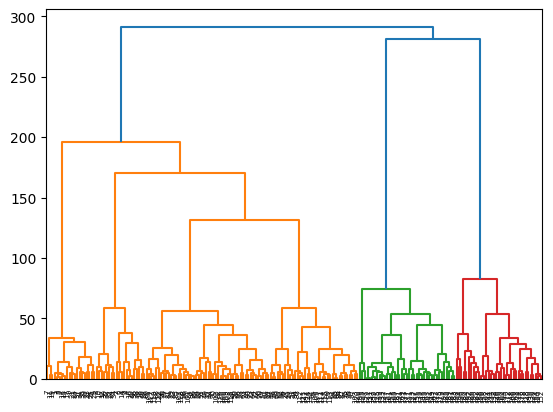

In [14]:
df = pd.read_csv('Mall_Customers.csv')
with pd.option_context('future.no_silent_downcasting', True):
    df["Gender"] = df["Gender"].replace(to_replace=['Male', 'Female'], value=[-1, 1]).infer_objects()
df = df.drop('CustomerID', axis=1)
X_ward = df.values

def ward(X, c1, c2):
    c1points = X[list(c1)]
    c2points = X[list(c2)]
    cluster = np.vstack((c1points, c2points))

    c1mean = c1points.mean(axis=0)
    c2mean = c2points.mean(axis=0)
    cluster_mean = cluster.mean(axis=0)

    intraESSc1 = np.sum((c1points - c1mean)**2)
    intraESSc2 = np.sum((c2points - c2mean)**2)
    jointESS = np.sum((cluster - cluster_mean)**2)

    return np.sqrt(jointESS - intraESSc1 - intraESSc2)


def find_pair(X, clusters):
    minDist = np.inf
    mergePair = (None, None)
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            dist = ward(X, clusters[i], clusters[j])
            if dist < minDist:
                minDist = dist
                mergePair = (i, j)
    return mergePair, minDist

def heirarchical_cluster(X, k = 1):
    n = X.shape[0]
    nextID = n
    clusters = {i: {i} for i in range(n)}

    link = np.zeros((n - k, 4))

    for itr in range(n - k):
        clusterList = list(clusters.values())

        (i, j), minDist = find_pair(X, clusterList)
        clusterID = list(clusters.keys())
        key_i = clusterID[i]
        key_j = clusterID[j]

        combCluster = clusters[key_i].union(clusters[key_j])
        clusters[nextID] = combCluster
        nextID += 1

        del clusters[key_i], clusters[key_j]
        link[itr] = [key_i, key_j, minDist, len(combCluster)]
    return link

link = heirarchical_cluster(X_ward, 1)

plt.figure()
sch.dendrogram(link)
plt.show()